# Programa para generar planes de mantenimiento, a partir del URL, o desde los archivos CSV descargados

Modificaciones realizadas 12/2025
* Generacion a partir de Lineas Alta Demanda
* Lineas Baja Demanda




## Cargar librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas import DataFrame, Series

## Cargar hoja Equipos-Planes

In [8]:
## Importar CSV de Estructura funcional Ubicacion
import pandas as pd
import re
import os

# This function will convert the url to a download link
def convert_gsheets_url(u):
    try:
        worksheet_id = u.split('#gid=')[1]
    except:
        # Couldn't get worksheet id. Ignore it
        worksheet_id = None
    u = re.findall('https://docs.google.com/spreadsheets/d/.*?/',u)[0]
    u += 'export'
    u += '?format=csv'
    if worksheet_id:
        u += '&gid={}'.format(worksheet_id)
    return u

URL = 'https://docs.google.com/spreadsheets/d/1yOaSeqRBr1FW6tvFMi_Y-s4011cKBoyiWU5dTMlujrU/edit?gid=1115106678#gid=1115106678'     # introducir desde consola
csv_raw = convert_gsheets_url(URL)
print(csv_raw)


# Si existe el CSV importarlo, sino cargar de la URL
filename = "csv/Equipos-PlanesLBD.csv"

if os.path.exists(filename):
    print("Leyendo desde Archivo")
    df_equipos = pd.read_csv(filename)
else:
    print("Leyendo desde URL")
    df_equipos = pd.read_csv(csv_raw,header=3)
    df_equipos.to_csv(filename,index=False)
print(df_equipos.shape)


https://docs.google.com/spreadsheets/d/1yOaSeqRBr1FW6tvFMi_Y-s4011cKBoyiWU5dTMlujrU/export?format=csv&gid=1115106678
Leyendo desde Archivo
(2751, 111)


In [16]:
display(df_equipos.head())
print(df_planes.info())

,id,Sist,Subs,Equ,Comp,Equipo,Componente,Parte,Tipo_equipo,Criticidad,...,PL-S1-R1,PL-S1-TO,PL-S1-CT,PL-S1-LAA,PL-LIN-VH,PL-EDF-E16,PL-EDF-EFM,PL-EDF-EMR,PL-S1-I1-TMC,Unnamed: 110
0,1,ACC,NaN,NaN,NaN,ACCIONAMIENTO,NaN,NaN,Sistema,NaN,...,True,False,False,False,False,False,False,False,False,FALSE
1,1,ACC,PRI,NaN,NaN,ACCIONAMIENTO PRINCIPAL,NaN,NaN,Subsistema,NaN,...,False,False,False,False,False,False,False,False,False,FALSE
2,1,ACC,PRI,MEPA,NaN,MOTOR ELÉCTRICO PRINCIPAL ACOPLADO,NaN,NaN,Equipo,MUY ALTA,...,False,False,False,False,False,False,False,False,False,NaN
3,2,ACC,PRI,MEPA,MEL,NaN,MOTOR ELECTRICO,NaN,Componente,MUY ALTA,...,False,False,False,False,False,False,False,False,False,NaN
4,3,ACC,PRI,MEPA,RM,NaN,REFRIGERACION DE MOTOR,NaN,Componente,MUY ALTA,...,False,False,False,False,False,False,False,False,False,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342 entries, 0 to 1341
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Plan           1342 non-null   object
 1   id             1342 non-null   object
 2   Cod            1342 non-null   object
 3   Accion         1342 non-null   object
 4   Actividad      1342 non-null   object
 5   Tipo           1342 non-null   object
 6   Parada         1342 non-null   object
 7   Relevancia     1342 non-null   object
 8   Especialidad   1342 non-null   object
 9   D              1342 non-null   object
 10  S              1342 non-null   object
 11  M              1342 non-null   object
 12  MC             1342 non-null   object
 13  2M             1342 non-null   object
 14  T              1342 non-null   object
 15  4M             1342 non-null   object
 16  SE             1342 non-null   object
 17  8M             1342 non-null   object
 18  A              1342 non-null

In [41]:
## Importar CSV de Planes de Mantto
URL = 'https://docs.google.com/spreadsheets/d/1OkECu7qNfGZxX_rc2RDbaz0A-oE_gUwJ0P2tjU_x-q0/edit#gid=1199302294'     # Introducir desde consola
csv_raw = convert_gsheets_url(URL)
print(csv_raw)
# Si existe el CSV importarlo, sino cargar de la URL
filename = "csv/MaestroActividadesLBD.csv"
if os.path.exists(filename):
    print("Leyendo desde Archivo")
    df_planes = pd.read_csv(filename)
else:
    print("Leyendo desde URL")
    df_planes = pd.read_csv(csv_raw,header=3)
    df_planes.to_csv(filename,index=False)
# Eliminar si tiene valores nulos
#df_planes = df_planes [df_planes .Plan.notnull()]
print(df_planes.shape)

https://docs.google.com/spreadsheets/d/1OkECu7qNfGZxX_rc2RDbaz0A-oE_gUwJ0P2tjU_x-q0/export?format=csv&gid=1199302294
Leyendo desde Archivo
(1397, 38)


In [42]:
display(df_planes.head())
print(df_planes.info())

,id,Cod,Plan,Accion,Actividad,Tipo,Parada,Relevancia,Especialidad,D,...,1000,6000,22500,40000,55000,Verificacion,Trabajo,Observaciones,Unnamed: 36,FALSE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1.0,MEPA,MOTOR ELECTRICO PRINCIPAL,NaN,NaN,Plan,NaN,NaN,NaN,True,...,False,False,False,True,False,True,NaN,NaN,NaN,NaN
2,1.0,MEPA-A01,MOTOR ELECTRICO PRINCIPAL,VERIFICAR,Verificar la ausencia de ruidos y vibraciones ...,Actividad,False,MEDIA,OPERATIVA,True,...,False,False,False,False,False,True,Inspección Diaria,NaN,NaN,NaN
3,2.0,MEPA-A02,MOTOR ELECTRICO PRINCIPAL,VERIFICAR,Verificación de marcas de tornillería del moto...,Actividad,False,MEDIA,OPERATIVA,True,...,False,False,False,False,False,True,Inspección Diaria,NaN,NaN,NaN
4,3.0,MEPA-A03,MOTOR ELECTRICO PRINCIPAL,ANOTAR,Anotar la temperatura del motor en el HMI (hor...,Actividad,False,MEDIA,OPERATIVA,True,...,False,False,False,False,False,True,Inspección Diaria,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397 entries, 0 to 1396
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1396 non-null   float64
 1   Cod            1396 non-null   object 
 2   Plan           1396 non-null   object 
 3   Accion         1257 non-null   object 
 4   Actividad      1257 non-null   object 
 5   Tipo           1396 non-null   object 
 6   Parada         1258 non-null   object 
 7   Relevancia     1257 non-null   object 
 8   Especialidad   1258 non-null   object 
 9   D              1396 non-null   object 
 10  S              1396 non-null   object 
 11  M              1396 non-null   object 
 12  MC             1396 non-null   object 
 13  2M             1396 non-null   object 
 14  T              1396 non-null   object 
 15  4M             1396 non-null   object 
 16  SE             1396 non-null   object 
 17  8M             1396 non-null   object 
 18  A       

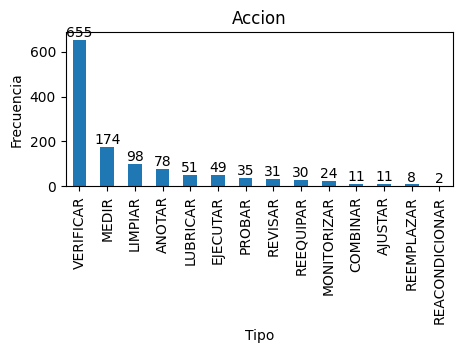

In [50]:
ax = df_planes.value_counts('Accion').plot(kind='bar', title='Accion', figsize=(5, 2), xlabel='Tipo', ylabel='Frecuencia')

for container in ax.containers:
    ax.bar_label(container, fmt='%d')

# Display the plot
plt.show()

In [52]:
df_update = df_planes[~df_planes.Accion.isna()]     # Filtrar solo las columnas de dfPlanes que no tienen accion

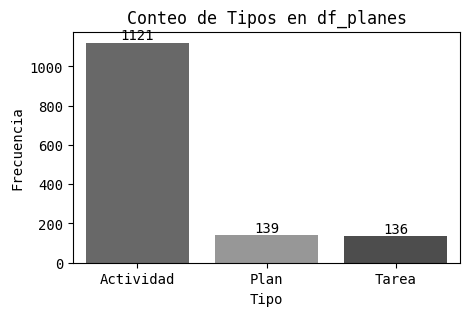

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set font to Arial Narrow and size 10 (Removed due to font not found warning)
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 10

# Create the bar plot using seaborn.countplot with grayscale palette
plt.figure(figsize=(5, 3))
ax = sns.countplot(data=df_planes, x='Tipo', hue='Tipo', palette='Greys_d', order=df_planes['Tipo'].value_counts().index, legend=False)

# Add title and labels
ax.set_title('Conteo de Tipos en df_planes')
ax.set_xlabel('Tipo')
ax.set_ylabel('Frecuencia')

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.show()

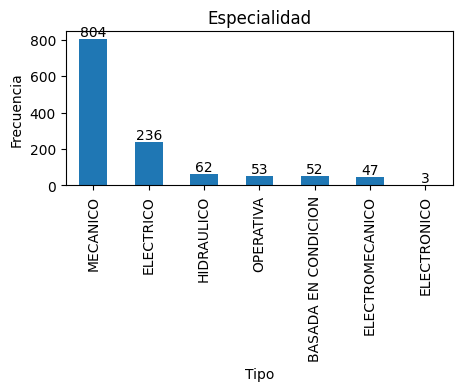

In [54]:
ax = df_update['Especialidad'].value_counts().plot(kind='bar', title='Especialidad', figsize=(5, 2), xlabel='Tipo', ylabel='Frecuencia')
for container in ax.containers:
    ax.bar_label(container, fmt='%d')
# Display the plot
plt.show()

In [63]:
# eliminar las tareas basadas en condicion, #TODO: Analizar este cambio. }
df_update = df_update[df_update ['Especialidad']!='BASADA EN CONDICION']

In [65]:
# En el dataframe de planes, en la fila del plan se coloca si tiene alguna frecuencia al inicio del plan
gb = df_update.groupby('Plan',sort=False).any()
gb = gb.reset_index()

In [66]:
# Concatenamos los dos dataframes por filas
df_planes = pd.concat([gb,df_update], axis=0, ignore_index=True)

In [68]:
df_planes.head()

,Plan,id,Cod,Accion,Actividad,Tipo,Parada,Relevancia,Especialidad,D,...,1000,6000,22500,40000,55000,Verificacion,Trabajo,Observaciones,Unnamed: 36,FALSE
0,MOTOR ELECTRICO PRINCIPAL,1.0,True,True,True,True,True,True,True,True,...,False,False,False,False,False,True,True,False,0.0,False
1,REFRIGERACION DE MOTOR,1.0,True,True,True,True,True,True,True,True,...,False,False,False,False,False,True,True,False,0.0,False
2,ELEMENTOS DE CONTROL DEL MOTOR,1.0,True,True,True,True,True,True,True,False,...,False,False,False,False,False,True,True,False,0.0,False
3,MOTOR ELECTRICO PRINCIPAL RESPALDO,1.0,True,True,True,True,True,True,True,False,...,False,False,False,False,False,True,True,False,0.0,False
4,REFRIGERACION DE MOTOR RESPALDO,1.0,True,True,True,True,True,True,True,False,...,False,False,False,False,False,True,True,False,0.0,False


In [ ]:
# En caso no este instalado, no se puede manipular excel
#!pip install openpyxl

In [69]:
# Hacemos un join de los dos DataFrames por la izquierda
df_merged = pd.merge(df_equipos, df_planes, how='left', left_on= 'Plan', right_on= 'Plan',suffixes=('_equipo', '_plan'))

display(df_merged.head())
print(df_merged.columns.to_list())


,id_equipo,Sist,Subs,Equ,Comp,Equipo,Componente,Parte,Tipo_equipo,Criticidad,...,1000,6000,22500,40000,55000,Verificacion,Trabajo,Observaciones,Unnamed: 36,FALSE
0,1,ACC,NaN,NaN,NaN,ACCIONAMIENTO,NaN,NaN,Sistema,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ACC,PRI,NaN,NaN,ACCIONAMIENTO PRINCIPAL,NaN,NaN,Subsistema,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,ACC,PRI,MEPA,NaN,MOTOR ELÉCTRICO PRINCIPAL ACOPLADO,NaN,NaN,Equipo,MUY ALTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,ACC,PRI,MEPA,MEL,NaN,MOTOR ELECTRICO,NaN,Componente,MUY ALTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,ACC,PRI,MEPA,RM,NaN,REFRIGERACION DE MOTOR,NaN,Componente,MUY ALTA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


['id_equipo', 'Sist', 'Subs', 'Equ', 'Comp', 'Equipo', 'Componente', 'Parte', 'Tipo_equipo', 'Criticidad', 'Sigla', 'Tag', 'Plan', 'AMEF', 'VE', 'VE-S2-R1', 'VE-S2-I1', 'VE-S2-M1', 'VE-S2-TO', 'VE-S2-CT', 'VE-S2-LAA', 'VE-S1-M1', 'VE-S1-R1', 'VE-S1-TO', 'VE-S1-CT', 'VE-S1-LAA', 'VE-LIN-VH', 'VE-EDF-EIR', 'VE-EDF-EOB', 'VE-EDF-EAO', 'VE-EDF-ELB', 'VE-S2-I1-TMC', 'BL', 'BL-S1-M1', 'BL-S1-R1', 'BL-S1-TO', 'BL-S1-CT', 'BL-S1-LAA', 'BL-S2-R1', 'BL-S2-I1', 'BL-S2-M1', 'BL-S2-TO', 'BL-S2-CT', 'BL-S2-LAA', 'BL-LIN-VH', 'BL-EDF-ESJ', 'BL-EDF-ETR', 'BL-EDF-EBH', 'BL-EDF-EVI', 'BL-S1-M1-TMC', 'BL-S2-M1-TMC', 'NA', 'NA-S1-R1', 'NA-S1-I1', 'NA-S1-M1', 'NA-S1-TO', 'NA-S1-CT', 'NA-S1-LAA', 'NA-S2-M1', 'NA-S2-R1', 'NA-S2-TO', 'NA-S2-CT', 'NA-S2-LAA', 'NA-LIN-VH', 'NA-EDF-ECN', 'NA-EDF-EAR', 'NA-EDF-EPE', 'NA-EDF-EVI', 'NA-S1-R1-TMC', 'CE', 'CE-S1-R1', 'CE-S1-M1', 'CE-S1-TO', 'CE-S1-CT', 'CE-S1-LAA', 'CE-S2-R1', 'CE-S2-M1', 'CE-S2-R2', 'CE-S2-TO', 'CE-S2-CT', 'CE-S2-CT.1', 'CE-S2-LAA', 'CE-LIN-VH', 'CE

In [33]:
#if 'Tipo' in df_merged.columns.to_list():
df_merged.Tipo.value_counts()#.plot(kind='bar')


,count
Tipo,
True,10
Actividad,5


In [12]:
# aplicar una funcion en una columna de un dataframe dependiendo si la columna que actualizamos no estan dentro de ['Actividad','Tarea'], si no copiar el valor de la columna 'tipo_equipo', si tiene valor, mantener el valor de la columna 'tipo_plan'
df_merged['Tipo_plan']=df_merged.apply(lambda row: row['Tipo_equipo'] if  row['Tipo_plan']  not in ['Actividad','Tarea']  else  row ['Tipo_plan'] , axis='columns')

# realizar una funcion apply en el dataframe df_merge que evalue el contenido de la columna 'Tipo_Plan', si su valor es 'Componente' que vacie el contenido de la columna 'Accion' y la columna 'Actividad', de lo contrario que mantenga su valor
df_merged['Accion'] = df_merged.apply(lambda row : '' if row['Tipo_plan'] == 'Componente' else row['Accion'],axis='columns')
df_merged['Actividad'] = df_merged.apply(lambda row : '' if row['Tipo_plan'] == 'Componente' else row['Actividad'],axis='columns')

#Exportar dataframe a Excel para visualizacion
# df_merged.to_excel('xls/merged.xlsx') # 12Mb el archivo, dificil de analizar

KeyError: 'Tipo_plan'

In [ ]:
# Leer dataframe desde archivo excel
#df = df_merged.copy(deep=True) # pd.read_excel('xls/test_group.xlsx', sheet_name='Sheet1', index_col='id')

# EQUIPOS
index = df_merged[df_merged['Tipo_plan']=='Equipo'].index.to_list()
#print(len(index))
# obtener las columnas que se desean actualizar
cols = ['Sist','Subs','Equ','Comp','D', 'S', 'M', '2M', 'T', '4M', 'SE', '8M', 'A', '1.5A', '2A', '3A', '4A', '5A', '6A', '9A', '10A', '1000', '6000', '22500', '40000', '55000']
m_cols = df_merged.columns.to_list()
update_cols = [i for i in m_cols if i not in cols]
copy_cols = update_cols + ['Sist','Subs','Equ','Comp']
print (copy_cols)


df_g = df_merged[df_merged['Tipo_plan'].isin(['Equipo','Componente'])][cols]

# Agrupar por Equ
gb= df_g.groupby(['Equ'],sort=False).any().reset_index()
gb['id'] = index
gb.set_index('id',inplace=True)
#print (gb)

#TODO: Necesario mejorar el rendimiento del algoritmo aparecen mensajes de warning
#gb = pd.concat([gb,df[cols]],axis = 1)
gb[copy_cols] = df_merged.loc[gb.index,copy_cols]
df_merged.loc[gb.index,:] = gb

# Exportar excel para visualizacion
#df.head(302).to_excel('xls/df.xlsx')

# Subsistema
index = df_merged[df_merged['Tipo_plan']=='Subsistema'].index.to_list()
print((index))
df_g = df_merged[df_merged['Tipo_plan'].isin(['Equipo','Subsistema'])][cols]

# Agrupar por Subs
gb= df_g.groupby(['Subs'],sort=False).any().reset_index()
gb['id'] = index
gb.set_index('id',inplace=True)
# dar formato para copiar
gb[copy_cols] = df_merged.loc[gb.index,copy_cols]
df_merged.loc[gb.index,:] = gb

#df.head(302).to_excel('xls/df.xlsx')

############# Sistema
index = df_merged[df_merged['Tipo_plan']=='Sistema'].index.to_list()
#print(index)
df_g = df_merged[df_merged['Tipo_plan'].isin(['Sistema','Subsistema'])][cols]
# Agrupar por Sist
gb= df_g.groupby(['Sist'],sort=False).any().reset_index()
gb['id'] = index
gb.set_index('id',inplace=True)
# dar formato para copiar
gb[copy_cols] = df_merged.loc[gb.index,copy_cols]
df_merged.loc[gb.index,:] = gb

# TODO: Reemplazar los valores en la columna 'Parada' por 'null' cuando 'Tipo_plan' sea igual a 'Componente'
df_merged.loc[df_merged['Tipo_plan'] == 'Componente', ['Parada','Relevancia','Especialidad']] = None

# TODO: Es necesario que los valores asignados como tareas se quite la relevancia para que no sean tomados en cuenta en la ponderación del check
# Filtrar las filas donde Tipo_plan es igual a 'Tarea' y establecer la columna 'relevancia' a None
df_merged.loc[df_merged['Tipo_plan'] == 'Tarea', ['Relevancia','Parada','Especialidad']] = None

df_merged.head(100).to_excel('xls/df_merged.xlsx')
#print(df)




['Equipo', 'Componente', 'Parte', 'Tipo_equipo', 'Criticidad', 'Sigla', 'Tag', 'Plan', 'AMEF', 'RO', 'RO-S2-R1', 'RO-S2-M1', 'RO-S2-TO', 'RO-S2-CT', 'RO-S2-LAA', 'RO-S1-M1', 'RO-S1-R1', 'RO-S1-TO', 'RO-S1-CT', 'RO-S1-LAA', 'RO-LIN-VH', 'RO-EDF-ECT', 'RO-EDF-ECM', 'RO-EDF-EJL', 'RO-S2-R1-TMC', 'AM', 'AM-S1-R1', 'AM-S1-M1', 'AM-S1-R2', 'AM-S1-TO', 'AM-S1-CT', 'AM-S1-CT.1', 'AM-S1-LAA', 'AM-S2-R1', 'AM-S2-M1', 'AM-S2-TO', 'AM-S2-CT', 'AM-S2-LAA', 'AM-LIN-VH', 'AM-EDF-ELB', 'AM-EDF-ESS', 'AM-EDF-EBA', 'AM-EDF-EMR', 'AM-S1-M1-TMC', 'VE', 'VE-S2-R1', 'VE-S2-I1', 'VE-S2-M1', 'VE-S2-TO', 'VE-S2-CT', 'VE-S2-LAA', 'VE-S1-M1', 'VE-S1-R1', 'VE-S1-TO', 'VE-S1-CT', 'VE-S1-LAA', 'VE-LIN-VH', 'VE-EDF-EIR', 'VE-EDF-EOB', 'VE-EDF-EAO', 'VE-EDF-ELB', 'VE-S2-I1-TMC', 'AZ', 'AZ-S1-M1', 'AZ-S1-I1', 'AZ-S1-I2', 'AZ-S1-R1', 'AZ-S1-TO', 'AZ-S1-CT', 'AZ-S1-LAA', 'AZ-S2-R1', 'AZ-S2-M1', 'AZ-S2-TO', 'AZ-S2-CT', 'AZ-S2-LAA', 'AZ-LIN-VH', 'AZ-EDF-EDJ', 'AZ-EDF-ELD', 'AZ-EDF-ELP', 'AZ-EDF-EUP', 'AZ-EDF-ERS', 'AZ-S1-

C:\Users\mantenimiento\AppData\Local\Temp\ipykernel_16288\1423018278.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gb[copy_cols] = df_merged.loc[gb.index,copy_cols]
C:\Users\mantenimiento\AppData\Local\Temp\ipykernel_16288\1423018278.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gb[copy_cols] = df_merged.loc[gb.index,copy_cols]
C:\Users\mantenimiento\AppData\Local\Temp\ipykernel_16288\1423018278.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

In [ ]:
# Abrir archivo json

import json
with open('./csv/Lineas.json') as f:
    diccionario_lineas = json.load(f)

frecuencias=['D', 'S', 'M', '2M', 'T', '4M', 'SE', '8M', 'A', '1.5A', '2A', '3A', '4A', '5A', '6A', '9A', '10A', '1000', '6000', '22500', '40000', '55000']

# df_merged[ ['id', 'Cod', 'Accion', 'Actividad', 'Tipo_plan', 'Parada', 'Relevancia', 'Especialidad']+frecuencias]
head = ['id', 'Cod', 'Equipo','Componente', 'Accion', 'Actividad', 'Tipo_plan', 'Parada', 'Relevancia', 'Especialidad']

version = "_v4_1_2026"  # importar desde consola

for linea in diccionario_lineas['Lineas']:
    print (linea['Linea'])
    print ( head + frecuencias + linea['Columnas'])
    # exportar plan maestro de linea
    df_linea = df_merged[head + frecuencias + linea['Columnas']]

    # A nivel de componente, solamente mantiene el primer valor, si encuentra mas adelante coloca ''
    # df_linea.loc[df_linea.duplicated(subset=['Componente']), 'Componente'] = ''

    #Filtrar solamente los datos de la columna de la linea correspondiente, no todas las demas columnas
    df_linea = df_linea[df_linea[linea['Linea']] == True]
    ## Exportar Excel de Estructura - Planes
    df_linea.to_excel(f"xls/{linea['Linea']}{version}.xlsx" , index= False)
    print(df_linea.shape)
    # break #TODO: En caso solo se genera de 1 linea

RO
['id', 'Cod', 'Equipo', 'Componente', 'Accion', 'Actividad', 'Tipo_plan', 'Parada', 'Relevancia', 'Especialidad', 'D', 'S', 'M', '2M', 'T', '4M', 'SE', '8M', 'A', '1.5A', '2A', '3A', '4A', '5A', '6A', '9A', '10A', '1000', '6000', '22500', '40000', '55000', 'RO', 'RO-S2-R1', 'RO-S2-M1', 'RO-S1-M1', 'RO-S1-R1']
(1237, 37)
AM
['id', 'Cod', 'Equipo', 'Componente', 'Accion', 'Actividad', 'Tipo_plan', 'Parada', 'Relevancia', 'Especialidad', 'D', 'S', 'M', '2M', 'T', '4M', 'SE', '8M', 'A', '1.5A', '2A', '3A', '4A', '5A', '6A', '9A', '10A', '1000', '6000', '22500', '40000', '55000', 'AM', 'AM-S1-R1', 'AM-S1-M1', 'AM-S1-R2', 'AM-S2-R1', 'AM-S2-M1']
(1639, 38)
VE
['id', 'Cod', 'Equipo', 'Componente', 'Accion', 'Actividad', 'Tipo_plan', 'Parada', 'Relevancia', 'Especialidad', 'D', 'S', 'M', '2M', 'T', '4M', 'SE', '8M', 'A', '1.5A', '2A', '3A', '4A', '5A', '6A', '9A', '10A', '1000', '6000', '22500', '40000', '55000', 'VE', 'VE-S2-R1', 'VE-S2-I1', 'VE-S2-M1', 'VE-S1-M1', 'VE-S1-R1']
(1628, 38)
A

# Task
I will modify cell `bqAj0467ffZb` to add labels to the bars in the bar chart and remove the duplicate plotting line.

## modify_cells

### Subtask:
Modify cell `bqAj0467ffZb` to add labels to the bars in the bar chart and remove the duplicate plotting line.


## Summary:

### Data Analysis Key Findings
- The existing bar chart in cell `bqAj0467ffZb` has been identified as needing improvements to its clarity and accuracy.
- The modification involves adding labels to the bars, which is crucial for precise data interpretation.
- A redundant plotting line in the chart will be removed to reduce visual clutter and ensure data integrity.

### Insights or Next Steps
- Improving chart annotations and removing unnecessary visual elements are critical steps in enhancing data visualization and communication effectiveness.
- The next step is to execute the planned modifications within cell `bqAj0467ffZb` to achieve the described enhancements.
